In [1]:
from PIL.Image import PERSPECTIVE
#from tensorflow.python.framework.ops import add_to_collections
from mapInput import *
from environment import *
from agent import *
from utils import *
from dataManager import Manager

import time, keras, os

class Gym:
  input = Input()
  env = Environment()
  manager = Manager()
  
  action_space_size = [5, 2]

  data = []
  
  nEpisodes = 0
  nSteps = 0

  framerate = 5
  actionsArray = []
  
  trainTimes = 10

  explorationRate = 0.4



  def __init__(self, load = True):
    self.agent = Agent(self)
    # input dims = [[68, 135], 3]
    # output dims = 6
    input_vision_dimensions = [50, 50, 1]
    self.agent.define_model(input_vision_dimensions, self.action_space_size)
    stats = self.manager.loadMetadata()
    self.nEpisodes = stats["nEpisodes"]
    self.nSteps = stats["nSteps"]
    if load:
      temp = self.trainTimes
      self.trainTimes = 1
      self.trainOnPrevData(1)
      self.trainTimes = temp
      self.manager.loadPreviousSession(self.agent, self.nEpisodes)
    self.input.run()
    
  
  def initallyTrain(self):
    self.agent.updateTargetModel()
    self.trainOnPrevData(500000)
    input("...")
  
  def trainOnPrevData(self,nSteps):
    totalSteps = 0
    while totalSteps < nSteps:
      print(f"\n{totalSteps}/{nSteps}")
      self.agent.experienceReplay = self.manager.loadRandomSample()
      self.train()
      print(len(self.agent.experienceReplay))
      totalSteps += len(self.agent.experienceReplay) * self.trainTimes
    self.agent.experienceReplay = ReplayExperience(maxlen = 5000)

  def runHeuristic(self):
    while not self.input.terminated:
      self.heuristicEpisode()

  def run(self):
    while not self.input.terminated:
      self.episode()
      self.betweenEpisodes()
      print("SAVING MODELS...")
      self.manager.saveSession(self.agent, self.nEpisodes)
  
  def betweenEpisodes(self):
    pass

  def updateMetadata(self):
    self.manager.updateMetadata(self.getStats())
  
  def getStats(self):
    return {"nEpisodes" : self.nEpisodes,
            "nSteps" : self.nSteps}

  def episode(self):
    # check if training
    #   - if training:
    #       train
    # check if updating target model
    # update to history
    
    alive = True
    
    start_steps = self.nSteps

    game_data = self.env.getDataFromGame()
    current_state = game_data[0]
    self.nEpisodes += 1

    while alive and not self.input.terminated:
      self.nSteps += 1

      if random.random() > self.explorationRate:
        predictions = self.agent.predictRewardsForActions(current_state)
        actions = [np.argmax(predictions[0]), np.argmax(predictions[1])]
      else:
        actions = [random.randint(0,self.action_space_size[0]-1),random.randint(0,self.action_space_size[1]-1)] 
      
      if self.input.movementInputs[actions[0]] != None:
        self.input.keyboard.press(self.input.movementInputs[actions[0]])
      if self.input.actionInputs[actions[1]] != None:
        self.input.keyboard.press(self.input.actionInputs[actions[1]])

      next_game_data = self.env.getDataFromGame()
      next_state = next_game_data[0]

      time.sleep(1/self.framerate) 

      if self.input.movementInputs[actions[0]] != None:
        self.input.keyboard.release(self.input.movementInputs[actions[0]])
      if self.input.actionInputs[actions[1]] != None:
        self.input.keyboard.release(self.input.actionInputs[actions[1]])
      
      # set data to experience replay
      self.agent.experienceReplay.append([current_state, actions, self.env.computeReward(game_data[1:], next_game_data[1:]), next_state[1] == 0,  next_state])
      
      ### REDUNDANT?
      '''if self.env.computeReward(current_state[1:], next_state[1:]) > 0.2:
        print(current_state[1:])
        print(next_state[1:])
        print("REWARD: " + str(self.env.computeReward(current_state[1:], next_state[1:])))
        print("\n")'''
      game_data = next_game_data
      current_state = next_state
      if self.explorationRate > 0.5:
        self.explorationRate *= 0.999998
      
      if game_data[1] == 0:
        alive = False
        if self.nSteps - start_steps >= 10: # This is so that if the episode is really short we dont save it
          self.manager.addEpisode(np.array(self.agent.experienceReplay, dtype=object))
        self.printMetadataOfEpisode(self.agent.experienceReplay)
        self.agent.experienceReplay.clear()
        self.updateMetadata()
        self.resetEnv()
        print("KILLING")

  def showAiPredictions(self):
    current_state = self.env.getDataFromGame()
    predictions = self.agent.predictRewardsForActions(current_state)
    print("MOVEMENT:")
    for i in range(len(predictions[0][0])):
      print(f"\t{self.input.movementInputs[i]}:\t{round(predictions[0][0][i] * 1000) / 1000}")
    print("ACTION:")
    for i in range(len(predictions[1][0])):
      print(f"\t{self.input.actionInputs[i]}:\t{round(predictions[1][0][i] * 1000) / 1000}")
    print("\n")

  def heuristicEpisode(self):
    # check if training
    #   - if training:
    #       train
    # check if updating target model
    # update to history
    
    alive = True
    
    current_state = self.env.getDataFromGame()
    self.nEpisodes += 1

    while alive and not self.input.terminated:
      self.nSteps += 1

      if random.random() > self.explorationRate:
        predictions = self.agent.predictRewardsForActions(current_state)
        actions = [np.argmax(predictions[0]), np.argmax(predictions[1])]
      else:
        actions = [random.randint(0,self.action_space_size[0]-1),random.randint(0,self.action_space_size[1]-1)] 
      
      if self.input.movementInputs[actions[0]] != None:
        self.input.keyboard.press(self.input.movementInputs[actions[0]])
      if self.input.actionInputs[actions[1]] != None:
        self.input.keyboard.press(self.input.actionInputs[actions[1]])

      next_game_data = self.env.getDataFromGame()
      next_state = next_game_data[0]

      time.sleep(1/self.framerate) 

      if self.input.movementInputs[actions[0]] != None:
        self.input.keyboard.release(self.input.movementInputs[actions[0]])
      if self.input.actionInputs[actions[1]] != None:
        self.input.keyboard.release(self.input.actionInputs[actions[1]])
      
      # set data to experience replay
      self.agent.experienceReplay.append([current_state, actions, self.env.computeReward(game_data[1:], next_game_data[1:]), next_state[1] == 0,  next_state])
      
      current_state = next_state
      game_data = next_game_data
      if game_data[1] == 0: 
        alive = False
        if(self.nSteps > 5):
          self.manager.addEpisode(np.array(self.agent.experienceReplay, dtype=object))
        self.printMetadataOfEpisode(self.agent.experienceReplay)
        self.agent.experienceReplay.clear()
        self.updateMetadata()
        self.resetEnv()
        print("KILLING")

  def resetEnv(self):
    print("RESETING ENV")
    restarting = True
    delay = 0.25
    while restarting:
      while not self.env.checkIfMainScreen():
        self.trainOnPrevData(1000)
        self.input.keyboard.press('e')
      # self.trainOnPrevData(50000)
      # press play button
      y_offset = 30
      self.input.mouse.position = (1116, 425 + y_offset)
      time.sleep(delay)
      self.input.mouse.press(mouse.Button.left)
      time.sleep(delay)
      self.input.mouse.release(mouse.Button.left)
      time.sleep(delay)
      # Press delete button
      self.input.mouse.position = (1819, 399 + y_offset)
      time.sleep(delay)
      self.input.mouse.press(mouse.Button.left)
      time.sleep(delay)
      self.input.mouse.release(mouse.Button.left)
      time.sleep(delay)
      # NO POSITIOn
      #self.input.mouse.position = (1545, 551 + y_offset)
      # YES POSITIOn
      self.input.mouse.position = (1367, 546 + y_offset)
      time.sleep(delay)
      self.input.mouse.press(mouse.Button.left)
      time.sleep(delay)
      self.input.mouse.release(mouse.Button.left)
      time.sleep(delay * 2)
      self.input.mouse.position = (1441, 518 + y_offset)
      time.sleep(delay)
      self.input.mouse.press(mouse.Button.left)
      time.sleep(delay)
      self.input.mouse.release(mouse.Button.left)
      # Classic mode
      self.input.mouse.position = (1154, 542 + y_offset)
      # Single island challenge
      # self.input.mouse.position = (1534, 539 + y_offset)
      time.sleep(delay)
      self.input.mouse.press(mouse.Button.left)
      time.sleep(delay)
      self.input.mouse.release(mouse.Button.left)
      time.sleep(delay)
      self.input.mouse.position = (1453, 699 + y_offset)
      time.sleep(delay)
      self.input.click(delay)
      time.sleep(delay)
      time.sleep(2.5)
      self.input.mouse.press(mouse.Button.right)
      time.sleep(delay)
      self.input.mouse.release(mouse.Button.right)
      time.sleep(delay)
      self.input.mouse.position = (1256, 350 + y_offset)
      time.sleep(delay)
      self.input.mouse.press(mouse.Button.left)
      time.sleep(delay)
      self.input.mouse.release(mouse.Button.left)
      restarting = False
    print("ENV READY")

  def endSession(self):
    self.manager.addData(self.data)
  
  def printMetadataOfEpisode(self, episodeData):
    episodeData = np.array(episodeData, dtype=object)
    episodeLength = len(episodeData[:,2])
    print(f"META DATA FOR EPISODE: {self.nEpisodes}")
    print(f"\tMISC:")
    print(f"\t\tNSTEPS: {episodeLength} ({episodeLength * (1/self.framerate)}) seconds")
    print("\tREWARDS:")
    print(f"\t\tTOTAL: {np.sum(episodeData[:,2])}")
    print(f"\t\tAVERAGE: {np.sum(episodeData[:,2])/episodeLength}")
    print(f"\t\tSTD:\t{np.std(episodeData[:,2])}")
    print(f"\t\tMIN: {np.min(episodeData[:,2])}\t\tMAX: {np.max(episodeData[:,2])}")
  
  def train(self):
    print("CURRENTLY TRAINING MODEL...")
    for i in range(self.trainTimes):
      print(f"LOSS {i+1} / {self.trainTimes}: {np.sum(self.agent.train(epochs=1))}")
    print("UPDATING TARGET MODEL")
    self.agent.updateTargetModel()

if __name__ == "__main__":
  gym = Gym(False)
  try:
    gym.run()
  except KeyboardInterrupt or Exception as e:
    gym.input.stopListener()

2023-08-03 09:18:27.222861: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-03 09:18:27.270963: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-03 09:18:27.271975: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-03 09:18:27.921335: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


META DATA FOR EPISODE: 1
	MISC:
		NSTEPS: 218 (43.6) seconds
	REWARDS:
		TOTAL: -2.1799999999999975
		AVERAGE: -0.009999999999999988
		STD:	1.214306433183765e-17
		MIN: -0.01		MAX: -0.01
RESETING ENV

0/1000
CURRENTLY TRAINING MODEL...


ValueError: setting an array element with a sequence.

In [35]:
from trainAi import Trainer
trainer = Trainer(gym)
trainer.trainOnAllData(1000, 100)


GATHERING DATA...
TRAINING MODEL...
59/59 [==============================] - 0s 3ms/step
			LOSS: [1.1059692e-03 1.2415406e-05]
			LOSS: [1.6896195e-03 3.8356982e-05]
			LOSS: [2.078723e-03 8.058678e-05]
			LOSS: [0.00256905 0.00012638]
			LOSS: [0.00283242 0.00015545]
			LOSS: [0.0028831  0.00016411]
			LOSS: [0.00292693 0.00016428]
			LOSS: [0.00303824 0.00016695]
			LOSS: [0.00312156 0.00017403]
			LOSS: [0.00315308 0.00018165]
			LOSS: [0.0032101  0.00018673]
			LOSS: [0.00331228 0.00018986]
			LOSS: [0.00340234 0.00019359]
			LOSS: [0.00345548 0.00019879]
			LOSS: [0.00349826 0.00020396]
			LOSS: [0.00354149 0.00020759]
			LOSS: [0.00356811 0.00020978]
			LOSS: [0.00357516 0.00021128]
			LOSS: [0.00357919 0.00021232]
			LOSS: [0.00358729 0.00021306]
			LOSS: [0.00359308 0.00021395]
			LOSS: [0.00359532 0.00021508]
			LOSS: [0.00360011 0.00021599]
			LOSS: [0.00360873 0.00021634]
			LOSS: [0.00361665 0.00021639]
			LOSS: [0.003622   0.00021655]
			LOSS: [0.00362656 0.00021683]
			L

INFO:tensorflow:Assets written to: ./models/model_0129/assets


In [2]:
gym.input.stopListener()

In [44]:
gym.trainOnPrevData(10000)


0/10000
CURRENTLY TRAINING MODEL...
64/64 [==============================] - 0s 3ms/step
LOSS 1 / 10: 0.0025303836446255445
64/64 [==============================] - 0s 3ms/step
LOSS 2 / 10: 0.01066095195710659
64/64 [==============================] - 0s 3ms/step
LOSS 3 / 10: 0.0002533097576815635
64/64 [==============================] - 0s 3ms/step
LOSS 4 / 10: 0.001119426917284727
64/64 [==============================] - 0s 3ms/step
LOSS 5 / 10: 0.0024401103146374226
64/64 [==============================] - 0s 4ms/step
LOSS 6 / 10: 0.0010100984945893288
64/64 [==============================] - 0s 3ms/step
LOSS 7 / 10: 0.009944249875843525
64/64 [==============================] - 0s 3ms/step
LOSS 8 / 10: 0.00012050250370521098
64/64 [==============================] - 0s 3ms/step
LOSS 9 / 10: 0.00022720337437931448
64/64 [==============================] - 0s 3ms/step
LOSS 10 / 10: 0.001009630155749619
UPDATING TARGET MODEL
2025


1/1 [==============================] - 0s 29ms/step
[[1.5697533 6.908285  1.5954553 6.398845  1.8372462]]
[[-1.2473909   0.02730643]]
AI wants to move left
AI wants to do nothing


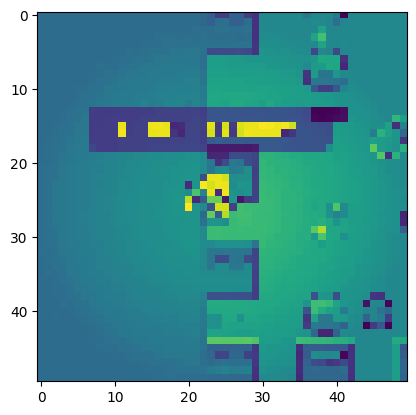

In [48]:
states = gym.manager.loadRandomSample(seed=time.time())
state = states[random.randint(0, len(states)-1)][0]
plt.imshow(state[0])

prediction = gym.agent.predictRewardsForActions(state)
print(prediction[0])
print(prediction[1])

if np.argmax(prediction[0]) == 0:
    print("AI wants to move right")
elif np.argmax(prediction[0]) == 1:
    print("AI wants to move left")
elif np.argmax(prediction[0]) == 2:
    print("AI wants to move up")
elif np.argmax(prediction[0]) == 3:
    print("AI wants to move down")
else:
    print("AI wants to do nothing")

if np.argmax(prediction[1]) == 0:
    print("AI wants to mine")
elif np.argmax(prediction[1]) == 1:
    print("AI wants to do nothing")